<font size="5">**Quantum Combinatorial Optimization for Distribution Network Reconfiguration**</font> 

***
This repository contains the supplementary material for the paper entitled "Evaluate Quantum Combinatorial Optimization for Distribution Network Reconfiguration" published on IEEE Xplore: https://ieeexplore.ieee.org/abstract/document/10012259

In the repsitory, the code of following sections are provided:
1. Customized data set bases on IEEE MATPOWER case33bw, 37 lines including 5 switches
2. Network configuration model
3. Implementation of ADMM using QAOA on a quantum computer of IBMQ cloud service
4. Visualization of quantum circuit

# Data Pre-processing

In [1]:
#Customized data set bases on IEEE MATPOWER case33bw - 37 LINES
import numpy as np
#               fbus, tbus,   r  ,    x    
#                 (0) (1)    (2)     (3)   
LData = np.array([[1,   2, 0.0575, 0.0293],
                  [2,   3, 0.3076, 0.1567],
                  [3,   4, 0.2284, 0.1163],
                  [4,   5, 0.2378, 0.1211],
                  [5,   6,  0.511, 0.4411],
                  [6,   7, 0.1168, 0.3861],
                  [7,   8, 0.4439, 0.1467],
                  [8,   9, 0.6426, 0.4617],
                  [9,  10, 0.6514, 0.4617],
                  [10, 11, 0.1227, 0.0406],
                  [11, 12, 0.2336, 0.0772],
                  [12, 13, 0.9159, 0.7206],
                  [13, 14, 0.3379, 0.4448],
                  [14, 15, 0.3687, 0.3282],
                  [15, 16, 0.4656, 0.34],
                  [16, 17, 0.8042, 1.0738],
                  [17, 18, 0.4567, 0.3581],
                  [ 2, 19, 0.1023, 0.0976],
                  [19, 20, 0.9385, 0.8457],
                  [20, 21, 0.2555, 0.2985],
                  [21, 22, 0.4423, 0.5848],
                  [ 3, 23, 0.2815, 0.1924],
                  [23, 24, 0.5603, 0.4424],
                  [24, 25, 0.559, 0.4374],
                  [ 6, 26, 0.1267, 0.0645],
                  [26, 27, 0.1773, 0.0903],
                  [27, 28, 0.6607, 0.5826],
                  [28, 29, 0.5018, 0.4371],
                  [29, 30, 0.3166, 0.1613],
                  [30, 31, 0.608, 0.6008],
                  [31, 32, 0.1937, 0.2258],
                  [32, 33, 0.2128, 0.3308],
                  [21,  8, 1.2479, 1.2479],
                  [ 9, 15, 1.2479, 1.2479],
                  [12, 22, 1.2479, 1.2479],
                  [18, 33, 0.312, 0.312],
                  [25, 29, 0.312, 0.312]])
#L = len(LData)
#print(L)
#MVAlim for 37 lines
MVAlim = np.array([270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270,
          270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270, 270])
L = 37
fr_bus = LData[:,0]
to_bus = LData[:,1]
r      = LData[:,2]
x      = LData[:,3]

In [2]:
#Read bus data from MATPOWER
#CVXPY, MOSEK and GUROBI
import cvxpy as cvx
import numpy as np
import math
import mosek
import gurobipy
# to run the following commands, please follow  https://www.instructables.com/id/Call-MATLAB-Script-and-Function-From-Python/
import matlab.engine
eng = matlab.engine.start_matlab()

#case = "case141"
case = "case33bw"
#case = "case22"
#case = "case18"
#case = "case33qiskit5"
#case = "case33qiskit3"
#case = "case4_dist"
#case = "case33bw_qiskit_13line"

ret = eng.Read_RadialNet_Matpower(case)  #case33bw, case123  # these command is equivalent to run Read_Matpower_Radial(case33bw) in Matlab
import scipy.io as spio #Reading Matlab mat data as Python dictionary
data = spio.loadmat('Radial_Netdata', squeeze_me=True) #taken from Matlab command Read_Matpower_Radial(Matpower_case_format);
#data contains the following parameters
#'Sbase', 'Pgmax', 'Pgmin', 'Qgmax', 'Qgmin', 'GenVarCost0', 'GenVarCost', 'G', 'B', 'MVAlim', 'connex', 'Pd', 'Qd', 'Vmax', 'Vmin','Gen2Bus'
#r = data['r']
#x = data['x']
slack_bus = 0
#slack_bus =55 #case 123 slackbus is 56 (Python index count from 0)
#slack_bus =113
I = len(data['Pd'])
G = data['G']
B = -data['B']
MVAlim =data['MVAlim']
status = data['status']

Define a connex function to check whether a pair of node $i,j=\ell \in \mathcal{L}$

In [ ]:
def connex(i,j,LData): #return 1 of (i,j) or (j,i) is a "connected" line
    temp = False
    for line in range(L):
        z1= (i== fr_bus[line]-1) and (j== to_bus[line]-1)
        z2= (j== fr_bus[line]-1) and (i== to_bus[line]-1)
        #z3= (data['status'][line]==1) #some lines are open switches
        #z= (z1 or z2) and z3
        z= (z1 or z2)
        temp = temp or z
    return temp

Normalize the data from MATPOWER

In [3]:
print(MVAlim)
if case =="case18":
    scale = 10
else:
    scale = 1    
data['Sbase']= scale*data['Sbase']
r = r*scale
x = x*scale
data['gs'] = data['gs']/scale
data['bs'] = data['bs']/scale


[270 270 270 270 270 270 270 270 270 270 270 270 270 270 270 270 270 270
 270 270 270 270 270 270 270 270 270 270 270 270 270 270]


# Network reconfiguration model - Classical computing

In [6]:
#CPLEX
import sys
import docplex.mp
from docplex.mp.model import Model
mdl = Model(name='Reconfiguration')

#Qiskit
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.translators import from_docplex_mp

In [7]:
#Branch flow model of Farivar and S. Low (Cleaner version)

data = spio.loadmat('Radial_Netdata', squeeze_me=True)
mdl.clear()
#Power flow variables
P  = mdl.continuous_var_matrix(keys1=I, keys2=I, name='P')
Q  = mdl.continuous_var_matrix(keys1=I, keys2=I, name='Q')
v  = mdl.continuous_var_list(I, ub=1, name='v') #Remember to remove ub of v[i], (just temporarily added to force v <=1 for quantum)
Isq= mdl.continuous_var_list(L, lb=0, name='Isq')

#Variables for relaxation of Demand sastifaction. In case some demands cannot be served -> relax the Pd constraint
Pds = mdl.continuous_var_list(I, lb=0, name='Pds')
Pc  = mdl.continuous_var_list(I, lb=0, name='Pc')
Qds = mdl.continuous_var_list(I, lb=0, name='Qds')
Qc  = mdl.continuous_var_list(I, lb=0, name='Qc')

#Network reconfiguration setting
vl    = mdl.continuous_var_matrix(keys1=L, keys2=I, lb=0, name='vl')
alpha = mdl.binary_var_list(L, name='alpha')
beta  = mdl.continuous_var_matrix(keys1=I, keys2=I, lb=0, name='beta')

### CONSTRAINTS
#Faulted lines scenario
#faultline = [19, 25] #Case 1
#faultline = [8, 11, 19] #Case 2
#faultline = [7, 11] #Case 3
#faultline = [3, 18] #Case 4
#faultline = [21, 26] #Case 5
faultline = [10, 20] #Case 6
#faultline = [22] #Case 7
#faultline = []


Delta = [1 for line in range(L)]
for line in faultline:
    Delta[line] = 0

#Power balance
P_outflow_of = [0 for i in range(I)]
Q_outflow_of = [0 for i in range(I)]
P_inflow_of  = [data['gs'][i]*v[i] for i in range(I)]
Q_inflow_of  = [data['bs'][i]*v[i] for i in range(I)]

for j in range(I):
    for k in range(I):
        for line in range(L):
            if Delta[line]==1:
                if (j==fr_bus[line]-1) and (k==to_bus[line]-1):
                    P_outflow_of[j] += P[j,k]
                    Q_outflow_of[j] += Q[j,k]                   
for j in range(I):
    for i in range(I):
        for line in range(L):
            if Delta[line]==1:
                if (i==fr_bus[line]-1) and (j==to_bus[line]-1):
                    P_inflow_of[j] += (P[i,j] - r[line]*Isq[line])
                    Q_inflow_of[j] += (Q[i,j] - x[line]*Isq[line])                       

 #Demand = Curtailment + Demand served
mdl.add_constraints(data['Pd'][j]/data['Sbase'] == Pc[j] + Pds[j] for j in range(I) if j != slack_bus)
mdl.add_constraints(data['Qd'][j]/data['Sbase'] == Qc[j] + Qds[j] for j in range(I) if j != slack_bus)

mdl.add_constraints(-(P_outflow_of[j] - P_inflow_of[j]) == Pds[j] for j in range(I) if j !=slack_bus)
mdl.add_constraints(-(Q_outflow_of[j] - Q_inflow_of[j]) == Qds[j] for j in range(I) if j !=slack_bus)

#Radiality constraints
#Beta(i,j) = 1 for all j connected to node i
for i in range(I):
    mdl.add_constraint(mdl.sum(beta[i,j] for j in range(I) if connex(i,j,LData) == 1) <= 1)    #Beta[i,j] = 0 or 1

mdl.add_constraints(beta[0,j] == 0 for j in range(I) if connex(0,j,LData) == 1)             #Beta[0,j] = 0

#Sectionalizing switches + Tie switches
SW = [L-1, L-2, L-3, L-4, L-5]
print(L)

#Switching operation
for line in range(L):    
    i = int(fr_bus[line]-1)
    j = int(to_bus[line]-1)
    mdl.add_constraint(beta[i,j] <= 1) #Already set ub = 1
    mdl.add_constraint(beta[j,i] <= 1)
    if line in SW:
        mdl.add_constraint(alpha[line] == (beta[j,i] + beta[i,j]))
        mdl.add_constraint(alpha[line] <= Delta[line])
    else:
        mdl.add_constraint(Delta[line] == (beta[j,i]+beta[i,j]))

    if line in SW:
        #For sectionalizing switches and tie switches
        mdl.add_constraint(vl[line,i] <= ((data['Vmax'][i])**2)*alpha[line]) #0<=vl[line,i]<=Vmax*alpha[line]
        mdl.add_constraint(vl[line,j] <= ((data['Vmax'][j])**2)*alpha[line]) #0<=vl[line,j]<=Vmax*alpha[line]
        mdl.add_constraint((v[i]-vl[line,i]) >= 0)
        mdl.add_constraint((v[i]-vl[line,i]) <=((data['Vmax'][i])**2)*(1-alpha[line]))  #0<=v[i]-vl[line,i]<=Vmax^2*(1-alpha[line])
        mdl.add_constraint((v[j]-vl[line,j]) >= 0)
        mdl.add_constraint((v[j]-vl[line,j]) <=((data['Vmax'][j])**2)*(1-alpha[line]))  #0<=v[j]-vl[line,j]<=Vmax^2*(1-alpha[line])
    else:
        #For non-sectionalizing switches
        mdl.add_constraint(vl[line,i] <= ((data['Vmax'][i])**2)*Delta[line]) #0<=vl[line,i]<=Vmax*Delta[line]
        mdl.add_constraint(vl[line,j] <= ((data['Vmax'][j])**2)*Delta[line]) #0<=vl[line,j]<=Vmax*Delta[line]
        mdl.add_constraint((v[i]-vl[line,i]) >= 0)
        mdl.add_constraint((v[i]-vl[line,i]) <=((data['Vmax'][i])**2)*(1-Delta[line]))  #0<=v[i]-vl[line,i]<=Vmax^2*(1-Delta[line])
        mdl.add_constraint((v[j]-vl[line,j]) >= 0)
        mdl.add_constraint((v[j]-vl[line,j]) <=((data['Vmax'][j])**2)*(1-Delta[line]))  #0<=v[j]-vl[line,j]<=Vmax^2*(1-Delta[line])

#=======================================================================================================================

#"""
aux1 = mdl.continuous_var_list(L, name='aux1') 
aux2 = mdl.continuous_var_list(L, name='aux2') 

for line in range(L):
    i = int(fr_bus[line]-1)
    j = int(to_bus[line]-1)
    if Delta[line] == 1:
        mdl.add_constraint(aux1[line] == 0.5*(vl[line,i] - Isq[line]))
        mdl.add_constraint(aux2[line] == 0.5*(vl[line,i] + Isq[line]))
#""" 

#Voltage drop and Conic constraint
for line in range(L):
    if Delta[line] == 1:
        i = int(fr_bus[line]-1)
        j = int(to_bus[line]-1)
        mdl.add_constraint(vl[line,j] == vl[line,i] - 2*(r[line]*P[i,j] + x[line]*Q[i,j]) + (r[line]**2 + x[line]**2)*Isq[line])
        #mdl.add_constraint(P[i,j]**2 + Q[i,j]**2 <= vl[line,i] * Isq[line])
        mdl.add_constraint((P[i,j]**2 + Q[i,j]**2 + (aux1[line])**2) <= (aux2[line])**2)

#Voltage limit constraint
#mdl.add_constraints(v[i] >= (data['Vmin'][i])**2 for i in range(I) if i!=slack_bus)
#mdl.add_constraints(v[i] <= (data['Vmax'][i])**2 for i in range(I) if i!=slack_bus)
for i in range(I): 
    if i!=slack_bus:
        mdl.add_constraint(v[i] >= (data['Vmin'][i])**2)
        mdl.add_constraint(v[i] <= (data['Vmax'][i])**2)

if case == "case18":
    mdl.add_constraint(v[slack_bus] == 1.1)
else:
    mdl.add_constraint(v[slack_bus] == 1)

#Objective function
Pgrid = P_outflow_of[slack_bus]*data['Sbase']
Qgrid = Q_outflow_of[slack_bus]*data['Sbase']

VOLL= 1000
ENS = data['Sbase']*(mdl.sum(Pc[j] for j in range(I) if j != slack_bus)) #Energy not served

mdl.minimize(Pgrid + ENS*VOLL)

mdl.print_information()
mdl.solve(clean_before_solve=True, log_output=True)
#mdl.report()
#mdl.print_solution()

print('Pgrid = ',Pgrid.solution_value)
print('Bus \t sum_Vl \t \t Vsq')
for i in range(I):
    print(i+1,'\t',sum(vl[line,i].solution_value for line in range(L)),'\t',v[i].solution_value)

print('L# \t Fr \t To \t Del \t Al \t Isq')
for line in range(L):
    print(str(line+1)+'\t'+str(fr_bus[line])+'\t'+str(to_bus[line])+'\t'+str(Delta[line])+'\t'+str(alpha[line].solution_value)+'\t'+str(Isq[line].solution_value))
"""
#Export solution to excel
import pandas as pd
buscol1 = list(range(I))
buscol2 = [v[i].solution_value for i in range(I)]
exceldat = pd.DataFrame({"Bus":buscol1,"Vsq":buscol2})
exceldat.to_excel('Case33_Bus_DOCPLEX_Low.xlsx',sheet_name='bus', index=False)

linecol1 = list(range(L))
linecol2 = [Isq[line].solution_value for line in range(L)]
exceldat = pd.DataFrame({"Line":linecol1,"Isq":linecol2})
exceldat.to_excel('Case33_Line_DOCPLEX_Low.xlsx',sheet_name='line', index=False)
"""

37
Model: Reconfiguration
 - number of variables: 4801
   - binary=37, integer=0, continuous=4764
 - number of constraints: 705
   - linear=670, quadratic=35
 - parameters: defaults
 - objective: minimize
 - problem type is: MIQCP
Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
Tried aggregator 4 times.
MIQCP Presolve eliminated 426 rows and 4478 columns.
MIQCP Presolve modified 18 coefficients.
Aggregator did 76 substitutions.
Reduced MIQCP has 169 rows, 249 columns, and 611 nonzeros.
Reduced MIQCP has 3 binaries, 0 generals, 0 SOSs, and 0 indicators.
Reduced MIQCP has 33 quadratic constraints.
Presolve time = 0.00 sec. (3.40 ticks)
Probing fixed 0 vars, tightened 6 bounds.
Probing time = 0.00 sec. (0.02 ticks)
Clique table members: 1.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 12 threads.
Root relaxation solution time = 0.00 sec. (0.73 ticks)

 

'\n#Export solution to excel\nimport pandas as pd\nbuscol1 = list(range(I))\nbuscol2 = [v[i].solution_value for i in range(I)]\nexceldat = pd.DataFrame({"Bus":buscol1,"Vsq":buscol2})\nexceldat.to_excel(\'Case33_Bus_DOCPLEX_Low.xlsx\',sheet_name=\'bus\', index=False)\n\nlinecol1 = list(range(L))\nlinecol2 = [Isq[line].solution_value for line in range(L)]\nexceldat = pd.DataFrame({"Line":linecol1,"Isq":linecol2})\nexceldat.to_excel(\'Case33_Line_DOCPLEX_Low.xlsx\',sheet_name=\'line\', index=False)\n'

# Quantum computing

## Check conflicted constraints

Make sure there is no SOS1, SOS2 constraints in the model

In [8]:
import docplex.mp.conflict_refiner as cr
solve_status = mdl.get_solve_status()
if solve_status.name == 'INFEASIBLE_SOLUTION':  # or also 'INFEASIBLE_OR_UNBOUNDED_SOLUTION'
    cref = cr.ConflictRefiner()
    print('show some of the constraints that can be removed to arrive at a minimal conflict')
    cref.refine_conflict(mdl, display=True)  # display flag is to show the conflicts

In [9]:
#print(mdl.export_as_lp_string())
print('Pgrid = ',Pgrid.solution_value)
print('Bus \t sum_Vl \t \t Vsq')
for i in range(I):
    print(i+1,'\t',sum(vl[line,i].solution_value for line in range(L)),'\t',v[i].solution_value)

print('L# \t Fr \t To \t Del \t Al \t Isq')
for line in range(L):
    print(str(line+1)+'\t'+str(fr_bus[line])+'\t'+str(to_bus[line])+'\t'+str(Delta[line])+'\t'+str(alpha[line].solution_value)+'\t'+str(Isq[line].solution_value))

Pgrid =  3.4858104542550414
Bus 	 sum_Vl 	 	 Vsq
1 	 1.0 	 1.0
2 	 2.98784803013149 	 0.9959493433771633
3 	 2.9301922338102546 	 0.9767307446034182
4 	 1.9345722085228894 	 0.9672861042614447
5 	 1.9161614137790677 	 0.9580807068895338
6 	 2.817027385531431 	 0.9390091285104771
7 	 1.8739971554614856 	 0.9369985777307428
8 	 1.8626289687789521 	 0.9313144843894761
9 	 2.776993949054398 	 0.9256646496847992
10 	 1.8485828052234545 	 0.9242914026117273
11 	 0.9241807043101866 	 0.9241807043101866
12 	 0.9188593311600384 	 0.9188593311600384
13 	 1.8377186623691386 	 0.9188593311845693
14 	 1.8377186623691386 	 0.9188593311845693
15 	 2.756578002063886 	 0.9188593340212954
16 	 1.8337873758141292 	 0.9168936879070646
17 	 1.8289296046790282 	 0.9144648023395141
18 	 0.9136401256483945 	 0.9136401256483945
19 	 1.9907634355162458 	 0.9953817177581229
20 	 1.9838293950333314 	 0.9919146975166657
21 	 0.9914358321741399 	 0.9914358321741399
22 	 0 	 0.81
23 	 1.9428707773293188 	 0.97143538

## Set up connect to IBMQ Cloud service

In [11]:
# Import Qiskit libaries
from qiskit import IBMQ, Aer
from qiskit.algorithms import QAOA, VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.providers.aer.noise.noise_model import NoiseModel

from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.converters import QuadraticProgramToQubo

import qiskit.test.mock as Fake #Quantum simulator (not real quantum); Quantum > Near-quantum (runtime) > Quantum simulator

In [12]:
#Run this command only once when receiving it from IBMQ. This command is to save token in PC, otherwise run IBMQ.update_account()
IBMQ.save_account('449340a846e733ba9acd11130b2ae2aebbc21ff321b5cc91adce91f84f09f7cabcc135fb7df6112cb3c867d171482d6144bfe836122a7f9ec93457a02892a828', overwrite=True) 

C:\Users\vnscn\AppData\Local\Temp\ipykernel_17876\2649064443.py:2: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  IBMQ.save_account('449340a846e733ba9acd11130b2ae2aebbc21ff321b5cc91adce91f84f09f7cabcc135fb7df6112cb3c867d171482d6144bfe836122a7f9ec93457a02892a828', overwrite=True)


In [14]:
#Check loading status and current active account
IBMQ.active_account()

{'token': '449340a846e733ba9acd11130b2ae2aebbc21ff321b5cc91adce91f84f09f7cabcc135fb7df6112cb3c867d171482d6144bfe836122a7f9ec93457a02892a828',
 'url': 'https://auth.quantum-computing.ibm.com/api'}

In [ ]:
#Run directly, the token is not saved in local PC. This kind of provider would be deleted once the notebook is closed.
provider = IBMQ.enable_account('449340a846e733ba9acd11130b2ae2aebbc21ff321b5cc91adce91f84f09f7cabcc135fb7df6112cb3c867d171482d6144bfe836122a7f9ec93457a02892a828')
backend_real = provider.get_backend('ibm_nairobi')

In [ ]:
from qiskit import IBMQ
IBMQ.update_account()

### Choose a real quantum computer

Maxium number of qubits for free usage is 7. If your problem has many binary variables, you should consider to use a simulator, instead.

In [13]:
#Load account and specify the server we want to use. Check the online composer before giving this information to get_backend
#Current available FREE servers: 7qubits: ibm_nairobi, ibm_oslo; 5qubits: manila, quito, belem, lima; 1qubit: armonk
provider = IBMQ.load_account()
#backend_real = provider.get_backend('ibm_nairobi')
backend_real = provider.get_backend('ibm_oslo')

### Choose a simulator

In [20]:
#This links with IBM Circuit online
from qiskit import IBMQ, assemble, transpile
from qiskit.circuit.random import random_circuit
provider = IBMQ.load_account()
# backend_real = provider.backend.ibmq_qasm_simulator
backend_real = provider.backend.simulator_stabilizer

ibmqfactory.load_account:WARNING:2023-02-19 23:32:34,932: Credentials are already in use. The existing account in the session will be replaced.


## Using ADMM
ADMM algorithm is employed to decompose the Mixed-integer Convex Program into
- Quadratic Unconstrained Binary Optimization Subproblem (QUBO). QUBO is solved by QAOA algorithm or Grover algorithm
- Convex Program is solved by a classical solver such as Gurobi or CPLEX

In [21]:
print('ADMMOptimizer')
import time
from typing import List, Optional, Any

from docplex.mp.model import Model

from qiskit import BasicAer
from qiskit.algorithms import QAOA, NumPyMinimumEigensolver
from qiskit_optimization.algorithms import CobylaOptimizer, MinimumEigenOptimizer
from qiskit_optimization.problems import QuadraticProgram
from qiskit_optimization.algorithms.admm_optimizer import ADMMParameters, ADMMOptimizer
from qiskit_optimization.translators import from_docplex_mp
#from qiskit_optimization.algorithms import CplexOptimizer # uncomment to use CPLEX instead
from qiskit_optimization.algorithms import GurobiOptimizer # uncomment to use GUROBI instead. Choose either Gurobi, cplex or cobyla for convex optimizer

#---

# define QAOA via the minimum eigen optimizer - Quantum algorithm
#qaoa = MinimumEigenOptimizer(QAOA(quantum_instance=BasicAer.get_backend("statevector_simulator")))

# define real quantum computer: 1/ Real QC, 2/Cloud-based simulator
quantum_instance_real = QuantumInstance(backend_real, shots=2048)
qaoa = MinimumEigenOptimizer(QAOA(quantum_instance=quantum_instance_real))

# exact QUBO solver as classical benchmark
#exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())  # to solve QUBOs

# in case CPLEX is installed it can also be used for the convex problems, the QUBO,
# or as a benchmark for the full problem.

#
# define optimizer to handle convex continuous problems.
#cobyla = CobylaOptimizer()
#cplex = CplexOptimizer() # uncomment to use CPLEX instead
gurobi = GurobiOptimizer()
#---

mod = from_docplex_mp(mdl)
#print(mod.export_as_lp_string())

#Parameters:
#admm_params = ADMMParameters(rho_initial=1001, beta=1000, factor_c=900, maxiter=100, three_block=True, tol=1.0e-6)
admm_params = ADMMParameters(
    rho_initial=100000, beta=10000000, factor_c=90000, maxiter=100000, vary_rho=1, max_time=100000, three_block=True, tol=1.0e-2, warm_start=True)

#Calling 3-ADMM-H algorithm
# define QUBO optimizer for binary
#qubo_optimizer = exact
qubo_optimizer = qaoa

#qubo_optimizer = cplex  # uncomment to use CPLEX instead (If CPLEX is used for qubo, this problem is not quantum)

# define classical optimizer for convex
#convex_optimizer = cobyla
#convex_optimizer = cplex  # uncomment to use CPLEX instead
convex_optimizer = gurobi  # uncomment to use GUROBI instead
#convex_optimizer = spsa  # uncomment to use spsa instead

# initialize ADMM with classical QUBO and convex optimizer
admm = ADMMOptimizer(params=admm_params, qubo_optimizer=qubo_optimizer, continuous_optimizer=convex_optimizer)
#admm = ADMMOptimizer(params=admm_params, qubo_optimizer=qubo_optimizer)

start_time = time.time()

# run ADMM to solve problem
result = admm.solve(mod)
print(result)
print("fval={:.2f}".format(result.fval))
#print("x={}".format(result))
print(result.variables_dict)
print("--- %s seconds ---" % (time.time() - start_time))

ADMMOptimizer
fval=333.48731011255387, P_0_0=0.0, P_0_1=0.03487261847137527, P_0_2=0.0, P_0_3=0.0, P_0_4=0.0, P_0_5=0.0, P_0_6=0.0, P_0_7=0.0, P_0_8=0.0, P_0_9=0.0, P_0_10=0.0, P_0_11=0.0, P_0_12=0.0, P_0_13=0.0, P_0_14=0.0, P_0_15=0.0, P_0_16=0.0, P_0_17=0.0, P_0_18=0.0, P_0_19=0.0, P_0_20=0.0, P_0_21=0.0, P_0_22=0.0, P_0_23=0.0, P_0_24=0.0, P_0_25=0.0, P_0_26=0.0, P_0_27=0.0, P_0_28=0.0, P_0_29=0.0, P_0_30=0.0, P_0_31=0.0, P_0_32=0.0, P_1_0=0.0, P_1_1=0.0, P_1_2=0.031097423633396952, P_1_3=0.0, P_1_4=0.0, P_1_5=0.0, P_1_6=0.0, P_1_7=0.0, P_1_8=0.0, P_1_9=0.0, P_1_10=0.0, P_1_11=0.0, P_1_12=0.0, P_1_13=0.0, P_1_14=0.0, P_1_15=0.0, P_1_16=0.0, P_1_17=0.0, P_1_18=0.002705014392260853, P_1_19=0.0, P_1_20=0.0, P_1_21=0.0, P_1_22=0.0, P_1_23=0.0, P_1_24=0.0, P_1_25=0.0, P_1_26=0.0, P_1_27=0.0, P_1_28=0.0, P_1_29=0.0, P_1_30=0.0, P_1_31=0.0, P_1_32=0.0, P_2_0=0.0, P_2_1=0.0, P_2_2=0.0, P_2_3=0.02052107967889287, P_2_4=0.0, P_2_5=0.0, P_2_6=0.0, P_2_7=0.0, P_2_8=0.0, P_2_9=0.0, P_2_10=0.0, P

In [10]:
# Refine result
#print(result.variables_dict)
import pandas as pd
#df = pd.DataFrame(result.variables_dict)
df = pd.Series(result.variables_dict).to_frame()
print(df)
"""
linecol1 = list(range(L))
linecol2 = [Isq[line].solution_value for line in range(L)]
exceldat = pd.DataFrame({"Line":linecol1,"Isq":linecol2})
exceldat.to_excel('Case33_Line_DOCPLEX_Low.xlsx',sheet_name='line', index=False)
"""
df.to_excel('Case33_All_Quantum.xlsx',sheet_name='All_data', index=True)

                    0
P_0_0    0.000000e+00
P_0_1    3.486038e-02
P_0_2    0.000000e+00
P_0_3    0.000000e+00
P_0_4    0.000000e+00
...               ...
aux2_32  9.602432e-12
aux2_33  4.559078e-01
aux2_34  2.832745e-01
aux2_35  1.186184e-01
aux2_36  1.200352e-11

[4801 rows x 1 columns]


In [ ]:
#Retrieve the last result of job [i]
job_real = backend_real.jobs()[0]
print(f"QAOA job created at {job_real.creation_date()} and has a job id of {job_real.job_id()}")

In [ ]:
job = backend_real.retrieve_job('62be798a4007f47ed6211b37')
#job = backend_real.retrieve_job()
job_result = job.result()
job_approx_execution_time = job_result.time_taken

## Visualization

In [2]:
from qiskit.tools.jupyter import *
IBMQ.load_account()

provider = IBMQ.get_provider(group='open', project='main')
system = provider.get_backend('ibm_oslo')
backend_real = system
system

<IBMQBackend('ibm_oslo') from IBMQ(hub='ibm-q', group='open', project='main')>

In [ ]:
from qiskit import QuantumCircuit, execute, IBMQ
from qiskit.visualization import plot_error_map
%matplotlib inline

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = provider.get_backend('ibm_oslo')
plot_error_map(backend)

## Circuit Drawing

In [6]:
# initialization
#import numpy as np

# import Qiskit
from qiskit import IBMQ, BasicAer
from qiskit.providers.ibmq import least_busy #Pick the least busy server (Free servers)
from qiskit import QuantumCircuit, execute
from qiskit.tools.jupyter import *
#provider= IBMQ.load.account()
system.configuration()
system.properties()

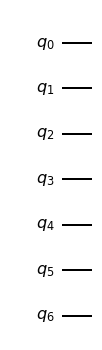

In [6]:
qc = QuantumCircuit(7)
qc.draw(output='mpl')

In [12]:
from qiskit import QuantumCircuit, transpile

qc2 = QuantumCircuit(7)
backend = backend_real
new_qc2 = transpile(qc2, backend)
new_qc2.draw()

#from qiskit.circuit.library import RealAmplitudes
#qc2 = RealAmplitudes(7, reps=7)
#qc2.draw(fold=120)

q_0 -> 0 
         
q_1 -> 1 
         
q_2 -> 2 
         
q_3 -> 3 
         
q_4 -> 4 
         
q_5 -> 5 
         
q_6 -> 6

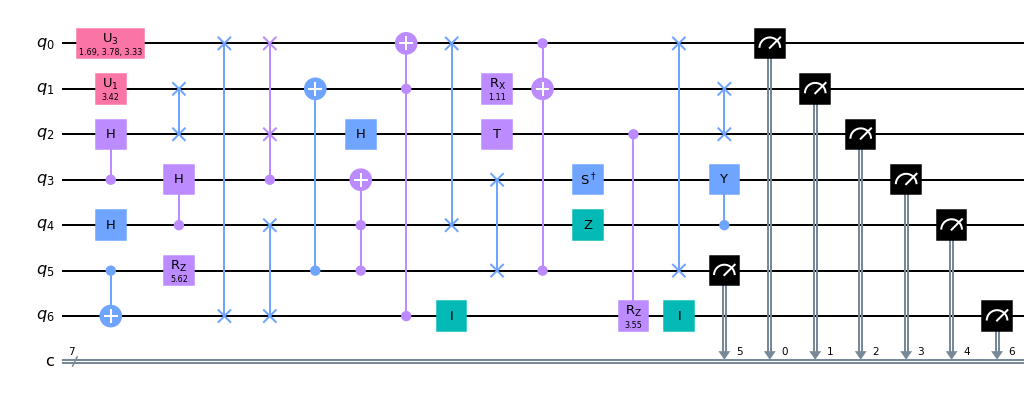

In [26]:
from qiskit.circuit.random import random_circuit

circ = random_circuit(7, 7, measure=True)
circ.draw(output='mpl')

In [35]:
# Draw a randum circuit for QAOA
qc_0 = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_0.h(i)
    
#qc_0.draw()
qc_qaoa = QuantumCircuit(nqubits)

qc_qaoa.append(qc_0, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_p, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_mix, [i for i in range(0, nqubits)])

qc_qaoa.decompose().decompose().draw(output='mpl', scale=1)
print(qc_qaoa.draw(output='latex_source'))

\documentclass[border=2px]{standalone}

\usepackage[braket, qm]{qcircuit}
\usepackage{graphicx}

\begin{document}
\scalebox{1.0}{
\Qcircuit @C=1.0em @R=1.0em @!R { \\
	 	\nghost{{q}_{0} :  } & \lstick{{q}_{0} :  } & \multigate{6}{\mathrm{circuit\mbox{-}528}}_<<<{0} & \multigate{6}{\mathrm{circuit\mbox{-}280}$\,(\mathrm{$\gamma})}_<<<{0} & \multigate{6}{\mathrm{circuit\mbox{-}278}$\,(\mathrm{$\beta})}_<<<{0} & \qw & \qw\\
	 	\nghost{{q}_{1} :  } & \lstick{{q}_{1} :  } & \ghost{\mathrm{circuit\mbox{-}528}}_<<<{1} & \ghost{\mathrm{circuit\mbox{-}280}$\,(\mathrm{$\gamma})}_<<<{1} & \ghost{\mathrm{circuit\mbox{-}278}$\,(\mathrm{$\beta})}_<<<{1} & \qw & \qw\\
	 	\nghost{{q}_{2} :  } & \lstick{{q}_{2} :  } & \ghost{\mathrm{circuit\mbox{-}528}}_<<<{2} & \ghost{\mathrm{circuit\mbox{-}280}$\,(\mathrm{$\gamma})}_<<<{2} & \ghost{\mathrm{circuit\mbox{-}278}$\,(\mathrm{$\beta})}_<<<{2} & \qw & \qw\\
	 	\nghost{{q}_{3} :  } & \lstick{{q}_{3} :  } & \ghost{\mathrm{circuit\mbox{-}528}}_<<<{3} & \ghost{